# Import modules and Config

In [4]:
import pandas as pd
import numpy as np
import gc
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import os, glob
import joblib
import random
import math
from tqdm import tqdm 
from collections import OrderedDict

from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import argrelmax

from sklearn.metrics import mean_squared_error

from math import pi, sqrt, exp
import sklearn,sklearn.model_selection
import torch
from torch import nn,Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim import AdamW
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler

from transformers import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModel

plt.style.use("ggplot")

from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import ctypes

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Fundamental config
NOTDEBUG = True # False -> DEBUG, True -> normally train
WORKERS = os.cpu_count() // 3
N_FOLDS = 5
TRAIN_FOLD = 0

SIGMA = 720 #average length of day is 24*60*12 = 17280 for comparison
SAMPLE_FREQ = 12 # 1 obs per minute

MAX_LEN = (24*60*12) # 1day per chunk
MAX_CHUNK_LEN = MAX_LEN // SAMPLE_FREQ
USE_AMP = False
SEED = 8620

In [7]:
# Model config
EMB_DIM = 32
MODEL_NAME = 'smallbenchnlp/roberta-small'
OUTPUT_DIR='./Roberta_Base'

In [8]:
# Optimizer config
LR = 4e-4
WD = 1e-2
WARMUP_PROP = 0.1
# LR_INIT = 1e-4
# LR_MIN = 1e-5

In [9]:
# Train config
EPOCHS = 10 if NOTDEBUG else 2
BS = 4
MAX_GRAD_NORM = 2.
GRAD_ACC = 32 // BS

In [10]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms = True
    # torch.backends.cudnn.benchmark = True

torch_fix_seed(SEED)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
def plot_history(history, model_path=".", show=True):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["valid_loss"], label="Validation Loss")
    plt.yscale('log')
    plt.title("Loss evolution")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(model_path, "loss_evo.png"))
    if show:
        plt.show()
    plt.close()

#     plt.figure()
#     plt.plot(epochs, history["valid_mAP"])
#     plt.title("Validation mAP evolution")
#     plt.xlabel("Epochs")
#     plt.ylabel("mAP")
#     plt.savefig(os.path.join(model_path, "mAP_evo.png"))
#     if show:
#         plt.show()
#     plt.close()

    plt.figure()
    plt.plot(epochs, history["lr"])
    plt.title("Learning Rate evolution")
    plt.xlabel("Epochs")
    plt.ylabel("LR")
    plt.savefig(os.path.join(model_path, "lr_evo.png"))
    if show:
        plt.show()
    plt.close()

# Define Model

In [13]:
class US_BLK(nn.Module):
    def __init__(self, in_c, out_c, in_len, ks=7, dilation=1, us_factor=2):
        super().__init__()
        padding = ((ks-1)*dilation)//2
        self.us = nn.Upsample(scale_factor=us_factor, mode='linear')
        self.conv1 = nn.Conv1d(in_c, out_c, ks, padding=padding, dilation=dilation)
        self.ln1 = nn.LayerNorm([out_c, in_len])
        self.act1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv1d(out_c, out_c, ks, padding=padding, dilation=dilation)
        self.ln2 = nn.LayerNorm([out_c, in_len])
        self.act2 = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.us(x)
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x = self.act2(x)
        return x
        
class BertEncoder(torch.nn.Module):
    
    def __init__(self, model_name, in_c=2, out_c=2, emb_dim=8, pretrained=True, base=96):
        super().__init__()
        
        self.config = AutoConfig.from_pretrained(model_name, add_pooling_layer=False)
        #self.config.relative_attention = False # ADD
        #self.config.num_hidden_layers = 12 # ADD
        #self.config.num_attention_heads = 6 # ADD
        #self.config.hidden_size = 384 # ADD
        
        if pretrained:
            self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        else:
            self.bert = AutoModel.from_config(self.config)
            
        self.bert = self.bert.encoder
        
        self.fc_in = nn.Linear(in_c, self.config.hidden_size-emb_dim)
        self.hr_emb = nn.Embedding(24, emb_dim)

        self.upsample_blocks = nn.ModuleList([])
        self.upsample_blocks.append(US_BLK(self.config.hidden_size, base*4, MAX_LEN//(2*2), us_factor=3))
        self.upsample_blocks.append(US_BLK(base*4, base*2, MAX_LEN//2, us_factor=2))
        self.upsample_blocks.append(US_BLK(base*2, base, MAX_LEN, us_factor=2))
        
        self.fc_out = nn.Linear(base, out_c)

    def forward(self, x, t, att_mask=None):
        # print(f'input x: {x.shape}')
        # print(f'input t: {t.shape}')
        x = self.fc_in(x)
        t = self.hr_emb(t)
        # print(f'fc_in x: {x.shape}')
        # print(f'hr_emb: {t.shape}')
        x = torch.cat([x, t.squeeze(2)], dim=-1)
        # print(f'after concat{x.shape}')
        
        # if att_mask is None:
        #     att_mask = torch.ones(x.size()[:2]).to(x.device)
        
        #print(f'att mask shape : {att_mask.shape}')
        bert_output = self.bert(x)
        #bert_output = self.bert(x, attention_mask=att_mask)
        x = bert_output.last_hidden_state
        # print(f'hidden state: {x.shape}')

        x = x.permute(0,2,1)

        for b in self.upsample_blocks:
            x = b(x)

        x = x.permute(0,2,1)
        
        scores = self.fc_out(x) 
        
        return scores

# Define Dataset and Fold split

In [14]:
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
metadata = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
unique_ids = metadata['series_id'].unique()
meta_cts = pd.DataFrame(unique_ids, columns=['series_id'])
for i, (train_index, valid_index) in enumerate(skf.split(X=meta_cts['series_id'], y=[1]*len(meta_cts))):
    if i != TRAIN_FOLD:
        continue
    print(f"Fold = {i}")
    train_ids = meta_cts.loc[train_index, 'series_id']
    valid_ids = meta_cts.loc[valid_index, 'series_id']
    print(f"Length of Train = {len(train_ids)}, Length of Valid = {len(valid_ids)}")
    
    if i == TRAIN_FOLD:
        break
        
train_fpaths = [f"/kaggle/input/detect-sleep-states-dataprepare/train_csvs/{_id}.csv" for _id in train_ids]
valid_fpaths = [f"/kaggle/input/detect-sleep-states-dataprepare/train_csvs/{_id}.csv" for _id in valid_ids]
train_ids[:5], train_fpaths[:5] ,len(train_fpaths)

Fold = 0
Length of Train = 221, Length of Valid = 56


(0    038441c925bb
 1    03d92c9f6f8a
 2    0402a003dae9
 3    04f547b8017d
 4    05e1944c3818
 Name: series_id, dtype: object,
 ['/kaggle/input/detect-sleep-states-dataprepare/train_csvs/038441c925bb.csv',
  '/kaggle/input/detect-sleep-states-dataprepare/train_csvs/03d92c9f6f8a.csv',
  '/kaggle/input/detect-sleep-states-dataprepare/train_csvs/0402a003dae9.csv',
  '/kaggle/input/detect-sleep-states-dataprepare/train_csvs/04f547b8017d.csv',
  '/kaggle/input/detect-sleep-states-dataprepare/train_csvs/05e1944c3818.csv'],
 221)

In [15]:
class SleepDataset(Dataset):
    def __init__(
        self,
        folder,
        max_len=17280,
        is_train=False,
        sample_per_epoch=10000
    ):
        self.enmo_mean = np.load('/kaggle/input/detect-sleep-states-dataprepare/enmo_mean.npy')
        self.enmo_std = np.load('/kaggle/input/detect-sleep-states-dataprepare/enmo_std.npy')
        
        self.max_len = max_len
        assert max_len % SAMPLE_FREQ == 0
        
        self.is_train = is_train
        
        self.max_df_size = 0
        self.min_df_size = 1e9
        
        self.sample_per_epoch = sample_per_epoch
        
        self.feat_list = ['anglez','enmo']
        
        self.Xys = self.read_csvs(folder)        
        
        self.label_list = ['onset', 'wakeup']
        
        self.hour_feat= ['hour']
        
        self.compress_methods = ['mean', 'median', 'fixed']
        
    def read_csvs(self, folder):
        res = []
        if type(folder) is str:
            files = glob.glob(f'{folder}/*.csv')
        else:
            files = folder
        for i, f in tqdm(enumerate(files), total=len(files), leave=False):
            df = pd.read_csv(f)
            df = self.norm_feat_eng(df, init=True if i==0 else False)
                
            res.append(df)
            self.max_df_size = max(self.max_df_size, len(df))
            self.min_df_size = min(self.min_df_size, len(df))
        return res
    
    def compress(self, xt, method='mean', sample_freq=SAMPLE_FREQ):
        x, t = xt
        seq_len = x.shape[0]
        if method == 'mean':
            x = x.reshape(seq_len//sample_freq, sample_freq, -1).mean(1)
            t = t.reshape(seq_len//sample_freq, sample_freq, 1).mean(1)
            
        if method == 'median':
            x = np.median(x.reshape(seq_len//sample_freq, sample_freq, -1), axis=1)
            t = np.median(t.reshape(seq_len//sample_freq, sample_freq, 1), axis=1)
            
        if method == 'fixed':
            start = torch.randint(0, sample_freq, size=(1,))[0].numpy()
            x = x[start::sample_freq]
            t = t[start::sample_freq]
        
        return x.astype(np.float32), t.astype(np.int32)

    def norm_feat_eng(self, X, init=False):
        X['anglez'] = abs(X['anglez'].diff()).fillna(method='bfill')
        X['enmo'] = (X['enmo'] - self.enmo_mean) / (self.enmo_std + 1e-12)
        
        for w in [1, 2, 4, 8, 16]:    
            X['anglez_shift_pos_' + str(w)] = X['anglez'].shift(w).fillna(0)
            X['anglez_shift_neg_' + str(w)] = X['anglez'].shift(-w).fillna(0)
            
            X['enmo_shift_pos_' + str(w)] = X['enmo'].shift(w).fillna(0)
            X['enmo_shift_neg_' + str(w)] = X['enmo'].shift(-w).fillna(0)
            
            if init:
                self.feat_list.append('anglez_shift_pos_' + str(w))
                self.feat_list.append('anglez_shift_neg_' + str(w))
                
                self.feat_list.append('enmo_shift_pos_' + str(w))
                self.feat_list.append('enmo_shift_neg_' + str(w))
            
        for r in [17, 33, 65]:
            tmp_anglez = X['anglez'].rolling(r, center=True)
            X[f'anglez_mean_{r}'] = tmp_anglez.mean()
            X[f'anglez_std_{r}'] = tmp_anglez.std()            
            
            tmp_enmo = X['enmo'].rolling(r, center=True)
            X[f'enmo_mean_{r}'] = tmp_enmo.mean()
            X[f'enmo_std_{r}'] = tmp_enmo.std()
            
            if init:
                self.feat_list.append(f'anglez_mean_{r}')
                self.feat_list.append(f'anglez_std_{r}')

                self.feat_list.append(f'enmo_mean_{r}')
                self.feat_list.append(f'enmo_std_{r}')
                
        X = X.fillna(0)
        
        return X.astype(np.float32)

    def gauss(self, n=SIGMA, sigma=SIGMA*0.15):
        # guassian distribution function
        r = range(-int(n/2),int(n/2)+1)
        return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]
    
    def __len__(self):
        return self.sample_per_epoch if self.is_train else len(self.Xys)

    def __getitem__(self, index):
        if self.is_train:
            ind = torch.randint(0, len(self.Xys), size=(1,))[0].numpy()
            Xy = self.Xys[ind]
            
            X = Xy[self.feat_list].values.astype(np.float32)
            y = Xy[self.label_list].values.astype(np.float32)
            t = Xy[self.hour_feat].values.astype(np.int32)

            if len(Xy)+1<self.max_len:
                res = self.max_len - len(Xy) + 1
                X = np.pad(X, ((0, res), (0, 0)))
                y = np.pad(y, ((0, res), (0, 0)))
                t = np.pad(t, ((0, res), (0, 0)))

            start = torch.randint(0, len(X)-self.max_len, size=(1,))[0].numpy()

            X = X[start:start+self.max_len]
            y = y[start:start+self.max_len]    
            t = t[start:start+self.max_len]    
            
            method_idx = torch.randint(0, len(self.compress_methods), size=(1,))[0].numpy()
            X, t = self.compress((X, t), method=self.compress_methods[method_idx])

        else:
            Xy = self.Xys[index]
            X = Xy[self.feat_list].values.astype(np.float32)
            y = Xy[self.label_list].values.astype(np.float32)        
            t = Xy[self.hour_feat].values.astype(np.int32)
            
            if len(Xy)%SAMPLE_FREQ!=0:
                res = SAMPLE_FREQ - (len(Xy)%SAMPLE_FREQ)
                X = np.pad(X, ((0, res), (0, 0)))
                y = np.pad(y, ((0, res), (0, 0)))
                t = np.pad(t, ((0, res), (0, 0)))
            
            X, t = self.compress((X, t), method='mean')
            
        return X, t, y

train_fpaths = train_fpaths if NOTDEBUG else train_fpaths[:25]
valid_fpaths = valid_fpaths if NOTDEBUG else valid_fpaths[:5]
sample_per_epoch = 20_000 if NOTDEBUG else 100

train_ds = SleepDataset(train_fpaths, max_len=MAX_LEN, is_train=True, sample_per_epoch=sample_per_epoch)
val_ds = SleepDataset(valid_fpaths, is_train=False)

In [16]:
np.save('feature_list.npy', train_ds.feat_list)

In [17]:
train_dl = DataLoader(
    train_ds,
    batch_size=BS,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
    drop_last=True
)
val_dl = DataLoader(
    val_ds,
    batch_size=1,
    pin_memory=True,
    num_workers=0,
    shuffle=False,
    drop_last=False
)

# Train and Eval

In [18]:
# https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, alpha=1., gamma=2.):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = self.alpha * (1-BCE_EXP)**self.gamma * BCE
                       
        return focal_loss.mean()

In [19]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if len(param.shape) == 1 or np.any([v in name.lower()  for v in skip_list]):
            # print(name, 'no decay')
            no_decay.append(param)
        else:
            # print(name, 'decay')
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [20]:
len(train_ds.feat_list)

34

In [21]:
def padding_(x, tgt_len=MAX_CHUNK_LEN):
    res = tgt_len - (x.size(-2) % tgt_len)
    x = F.pad(x, (0, 0, 0, res))
    return x

In [22]:
model = BertEncoder(
    model_name=MODEL_NAME, 
    in_c=len(train_ds.feat_list), 
    out_c=2, 
    emb_dim=EMB_DIM, 
    pretrained=True
).to(device)
model

config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.0M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at smallbenchnlp/roberta-small and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertEncoder(
  (bert): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): RobertaIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): RobertaOutput(
          (dense): Linear(in_features=1024, out_features=256,

In [23]:
n_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f'model has {n_params} params.')

model has 32081826 params.


In [24]:
optimizer_parameters = add_weight_decay(model, weight_decay=WD, skip_list=['bias'])
optimizer = AdamW(optimizer_parameters, lr=LR, eps=1e-6, betas=(0.9, 0.999))

In [25]:
steps = len(train_dl) * EPOCHS // GRAD_ACC
warmup_steps = int(steps * WARMUP_PROP)

print(steps, warmup_steps)

scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=steps,
                                            num_cycles=0.5)

dt = time.time()

model_path = OUTPUT_DIR

os.makedirs(model_path, exist_ok=True)



history = {
    "train_loss": [],
    "valid_loss": [],
    "lr": [],
}

best_valid_loss = 1e5

criterion = FocalLoss(alpha=1., gamma=2.)

6250 625


In [26]:
model_name_sep = MODEL_NAME.split('/')[-1]
torch.save(model.config, OUTPUT_DIR + f'/{model_name_sep}_config.pth')
model.config

RobertaConfig {
  "_name_or_path": "smallbenchnlp/roberta-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 128,
  "model_type": "roberta",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [27]:
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # if you are using newer GPU, recommended dtype=torch.bfloat16 than half
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

In [28]:
es_step = 0

100%|██████████| 56/56 [01:22<00:00,  1.48s/it]


1/10 --  train_loss = 0.011498 --  valid_loss = 0.007792 --  time = 4075.877162s


100%|██████████| 56/56 [01:23<00:00,  1.48s/it]


2/10 --  train_loss = 0.008115 --  valid_loss = 0.007835 --  time = 4047.561080s


100%|██████████| 56/56 [01:22<00:00,  1.48s/it]


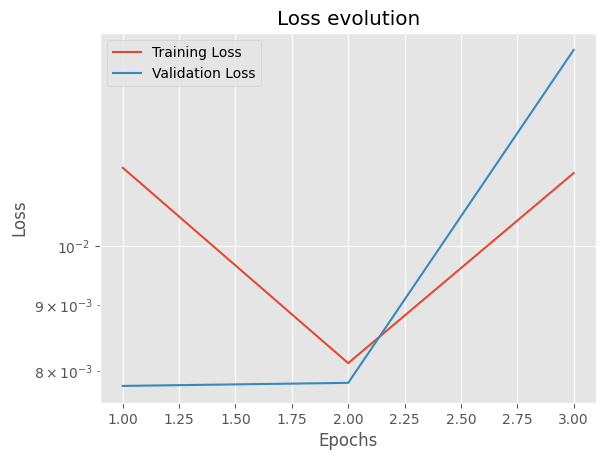

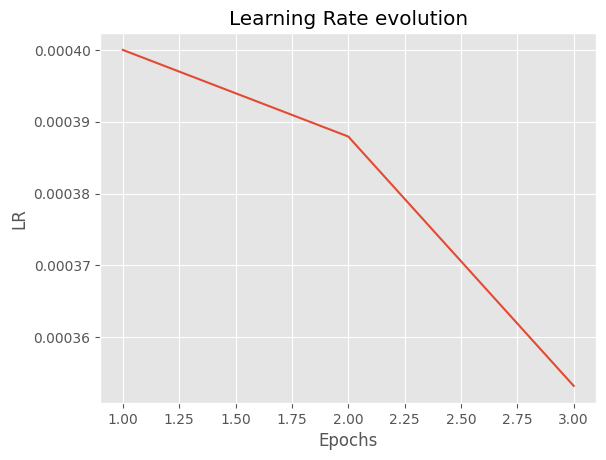

In [29]:
for epoch in range(EPOCHS):
    if epoch>=7: break
    total_loss = 0.0
    model.train()
    optimizer.zero_grad()
    with tqdm(train_dl, leave=True) as pbar:
        for step, (X_batch, hr_batch, y_batch) in enumerate(pbar):
            X_batch = X_batch.to(device)
            hr_batch = hr_batch.to(device)
            y_batch = y_batch.to(device)           
            with autocast:
                pred = model(X_batch, hr_batch)
                #break
                loss = criterion(pred, y_batch)
                
                if torch.isnan(loss).any():
                    raise RuntimeError('Detected NaN.')
    
                total_loss += loss.item()
                if GRAD_ACC > 1:
                    loss = loss / GRAD_ACC
                        
                pbar.set_postfix(
                        OrderedDict(
                            loss=f'{loss.item()*GRAD_ACC:.6f}',
                            lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                        )
                    )
        
                scaler.scale(loss).backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)
    
            if (step + 1) % GRAD_ACC == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()

        train_loss = total_loss/len(train_dl)
    

    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        with tqdm(val_dl, leave=True) as pbar:
            for step, (X_batch, hr_batch, y_batch) in enumerate(pbar):
                X_batch = X_batch.to(device)
                hr_batch = hr_batch.to(device)
                y_batch = y_batch.to(device)
                pred = torch.zeros_like(y_batch)
                x_seq_len = X_batch.shape[1]
                y_seq_len = y_batch.shape[1]

                if x_seq_len%MAX_CHUNK_LEN != 0:
                    X_batch = padding_(X_batch,MAX_CHUNK_LEN)
                    hr_batch = padding_(hr_batch,MAX_CHUNK_LEN)

                if y_seq_len%(MAX_CHUNK_LEN*SAMPLE_FREQ) != 0:
                    pred = padding_(pred,MAX_CHUNK_LEN*SAMPLE_FREQ)

                j = 0
                for i in range(0, x_seq_len, MAX_CHUNK_LEN):
                    X_chunk = X_batch[:, i : i + MAX_CHUNK_LEN]
                    hr_chunk = hr_batch[:, i : i + MAX_CHUNK_LEN]
                    with autocast:
                        p = model(X_chunk, hr_chunk)
                        pred[:, j : j + MAX_CHUNK_LEN*SAMPLE_FREQ] = p

                    j += MAX_CHUNK_LEN*SAMPLE_FREQ

                pred = pred[:, :y_seq_len]
                loss = criterion(pred, y_batch)
                
                total_loss += loss.item()
            
    valid_loss = total_loss/len(val_dl)
    
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(
            model.state_dict(),
            os.path.join(model_path, f"model_best_fold-{TRAIN_FOLD}.pth"),
        )
        es_step = 0
        
    else:
        es_step += 1
        if es_step >= 2:
            break

    dt = time.time() - dt
    print(
        f"{epoch+1}/{EPOCHS} -- ",
        f"train_loss = {train_loss:.6f} -- ",
        f"valid_loss = {valid_loss:.6f} -- ",
        f"time = {dt:.6f}s",
    )
    dt = time.time()

plot_history(history, model_path=model_path)
history_path = os.path.join(model_path, "history.json")
with open(history_path, "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=4)

# Verification

In [30]:
model.eval()

BertEncoder(
  (bert): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): RobertaIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): RobertaOutput(
          (dense): Linear(in_features=1024, out_features=256,

In [31]:
def lpf(wave, fs=12*60*24, fe=30, n=3):
    nyq = fs / 2.0
    b, a = signal.butter(1, fe/nyq, btype='low')
    for i in range(0, n):
        wave = signal.filtfilt(b, a, wave)
    return wave

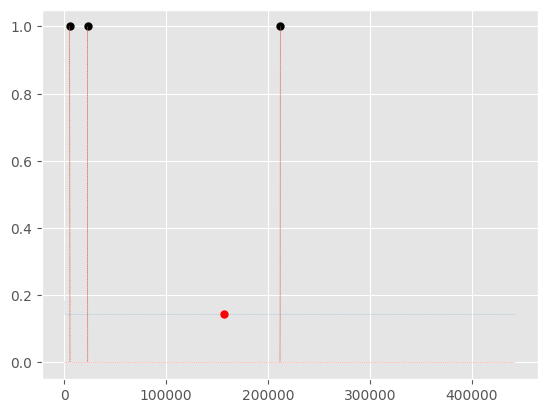

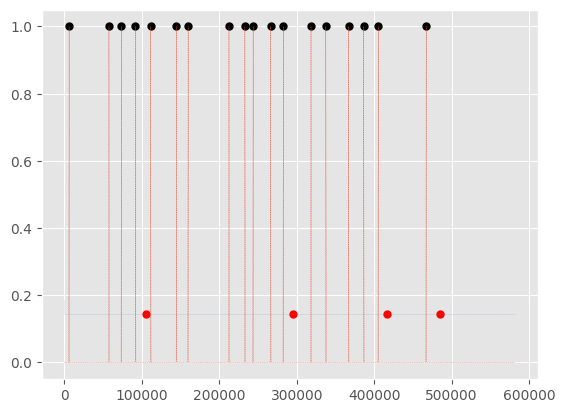

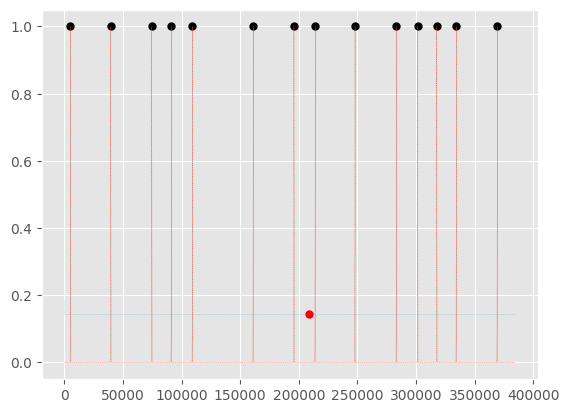

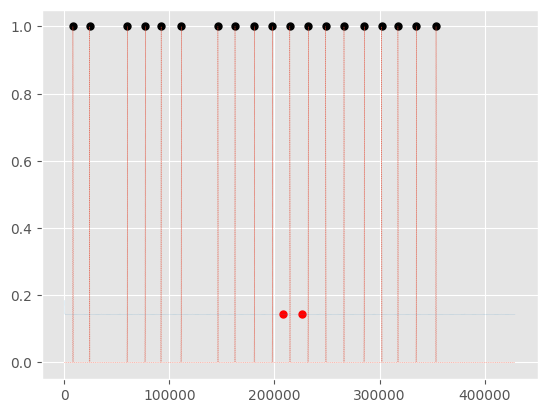

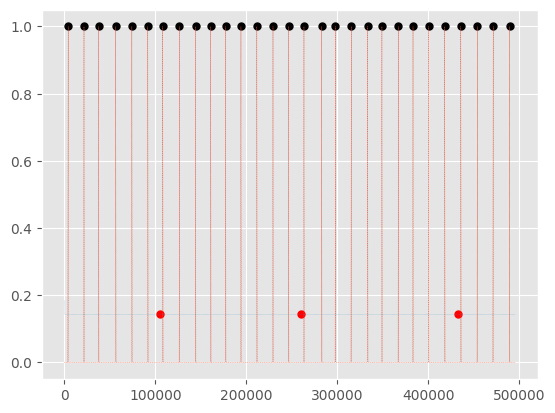

In [32]:
with torch.no_grad():
    for k, (x, h, y) in enumerate(val_dl):
        x = x.to(device)
        h = h.to(device)
        y = y.to(device)

        pred = torch.zeros_like(y)
        x_seq_len = x.shape[1]
        y_seq_len = y.shape[1]

        if x_seq_len%MAX_CHUNK_LEN != 0:
            x = padding_(x,MAX_CHUNK_LEN)
            h = padding_(h,MAX_CHUNK_LEN)
            pred = padding_(pred,MAX_CHUNK_LEN)

        if y_seq_len%(MAX_CHUNK_LEN*SAMPLE_FREQ) != 0:
            pred = padding_(pred,MAX_CHUNK_LEN*SAMPLE_FREQ)

        #print(x.shape,h.shape,y.shape,pred.shape)
        j = 0
        for i in range(0, x_seq_len, MAX_CHUNK_LEN):
            X_chunk = x[:, i : i + MAX_CHUNK_LEN]
            hr_chunk = h[:, i : i + MAX_CHUNK_LEN]
            with autocast:
                pred[:, j : j + MAX_CHUNK_LEN*SAMPLE_FREQ] = model(X_chunk, hr_chunk)
            j += MAX_CHUNK_LEN*SAMPLE_FREQ

        pred = pred[:, :y_seq_len]

        y_pred = pred[0].sigmoid().cpu().numpy()
        y = y[0].cpu().numpy()
        
        y_pred[:,0] = lpf(y_pred[:,0])
        y_pred[:,1] = lpf(y_pred[:,1])
        
        candi = argrelmax(y_pred[:, 0], order=12*60*6) # 12*60*6 = 6hours
        gt0 = argrelmax(y[:,0], order=12*30)

        plt.plot(gt0, y[gt0, 0], marker='o', markersize=5, c="black")
        plt.plot(candi, y_pred[candi, 0], marker='o', markersize=5, c="red")    
        plt.plot(y[:, 0], lw=0.25, label="GT", linestyle="dashed")
        plt.plot(y_pred[:, 0], lw=0.25, label="pred", linestyle="dotted")
        plt.show()
        plt.close()

        if k==4: break